In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using PrettyTables
using Statistics, LinearAlgebra
using FenrirForNeuro, ModelingToolkit, OrdinaryDiffEq
using FileIO
using StatsBase

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function import_csvs(fpaths, header=nothing)
    dfs = []
    for fpath in fpaths
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        df[!, :iter] = 1:size(df, 1)
        push!(dfs, df)
    end
    return dfs
end

get_last_rows(trajectories) = vcat([DataFrame(t[end, :]) for t in trajectories]...)


function where_converged(trajectories, threshold=5e-2)
    last_rows = get_last_rows(trajectories)
    pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(Array(last_rows[!, pkeys(θ)])))
    return pRMSEs .< 5e-2
end


l2 = get_l2_loss()

pkeys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
pvalues(θ) = map(θᵢ -> θᵢ[2], θ)

pvalues (generic function with 1 method)

In [3]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.5*HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [4]:
@parameters gNa gK 
θ = [gNa => 25, gK => 7]
prob_prior, prob = get_SinglecompartmentHH(θ)

proj = [1 0 0 0]
# observation = generate_data(prob, proj, 1e-2, 1e-2)

1×4 Matrix{Int64}:
 1  0  0  0

In [5]:
IN_PATH = RESULTS_PATH * "hh/2p/simple/fenrir/tempering_tradeoff"
FNAMES = readdir(IN_PATH)
FPATHS = [joinpath(IN_PATH, fname) for fname in FNAMES]
κ²0 = 20.0
T10(t::Real)::Float64 = 10.0^(κ²0 - t)
tempering_schedules = [T10.(LinRange(0, 20, n_steps)) for n_steps in 5:21]

IN_PATH = RESULTS_PATH * "hh/2p/simple/fenrir/exp_tempered_diff"
FNAMES = readdir(IN_PATH)
exp_fpaths = [joinpath(IN_PATH, fname) for fname in FNAMES]
κ²0 = 20.0
τ = 5.0;
T(t::Real)::Float64 = 10.0^(κ²0 * exp(-t / τ));
exp_tempering_schedule = T.(LinRange(0, 20, 21))
push!(tempering_schedules, exp_tempering_schedule)
last_rows_by_schedule = []
for (i, schedule) in enumerate(tempering_schedules)
    fpaths = i < length(tempering_schedules) ? filter(x -> occursin("-$i-", x), FPATHS) : exp_fpaths
    trajectories = import_csvs(fpaths, [pkeys(θ)..., :κ², :l, :T])
    last_rows_at_κ² = []
    last(x) = x[end, :]
    push!(last_rows_by_schedule, [combine(groupby(t, :κ²), last) for t in trajectories])
end
only_last_rows_by_schedule = [vcat([DataFrame(l[argmin(l[!, :κ²]), :]) for l in last_rows]...) for last_rows in last_rows_by_schedule]

18-element Vector{DataFrame}:
 97×6 DataFrame
 Row │ κ²       gNa      gK        l             T        iter  
     │ Float64  Float64  Float64   Float64       Float64  Int64 
─────┼──────────────────────────────────────────────────────────
   1 │     1.0   0.5     15.0         1.38266e7  1813.51    311
   2 │     1.0  24.9715   6.97769  2780.37       1777.19    280
   3 │     1.0   0.5     15.0         1.38266e7  1695.61    300
   4 │     1.0  24.9715   6.97769  2780.37       2498.44    469
   5 │     1.0  24.9715   6.97769  2780.37       1873.32    307
   6 │     1.0   0.5     15.0         1.38266e7  1447.57    253
   7 │     1.0  24.9715   6.97769  2780.37       1375.66    226
   8 │     1.0  24.9715   6.97769  2780.37       1597.87    250
  ⋮  │    ⋮        ⋮        ⋮           ⋮           ⋮       ⋮
  91 │     1.0  24.9715   6.97769  2780.37       2629.03    235
  92 │     1.0  24.9715   6.97769  2780.37       2290.66    220
  93 │     1.0  24.9715   6.97769  2780.37       2956.91 

In [302]:
metrics = []
metrics_per_κ² = []
for (i, schedule) in enumerate(tempering_schedules)
    only_last_rows = only_last_rows_by_schedule[i]
    all_last_rows = last_rows_by_schedule[i]
    metrics_cache = []
    for (k, rows) in enumerate([only_last_rows, schedule...])
        last_rows = k == 1 ? only_last_rows : vcat([DataFrame(last_row[k-1, :]) for last_row in all_last_rows]...)
        θ_est = Array(last_rows[!, pkeys(θ)])
        pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(θ_est))
        
        last_rows[!, :pRMSE] = [pRMSEs...]
        last_rows[!, :conv] = [(pRMSEs .< 5e-2)...]
        
        conv = mean(last_rows[!, :conv])
        pRMSE = mean(last_rows[!, :pRMSE])
        num_iter = mean(last_rows[!, :iter])
        push!(k == 1 ? metrics : metrics_cache, [conv, pRMSE, num_iter])
    end
    push!(metrics_per_κ², metrics_cache)
end
metrics = stack(metrics)'
metrics = map(x -> Float64(x), metrics)

metrics_per_κ² = [map(x -> Float64(x), hcat(metrics...)') for metrics in metrics_per_κ²]

18-element Vector{Matrix{Float64}}:
 [0.0 0.9637798443147313 115.51546391752578; 0.7628865979381443 0.19036113763393536 198.5979381443299; … ; 0.8041237113402062 0.21056081868159215 270.35051546391753; 0.8041237113402062 0.21039601120359233 287.3917525773196]
 [0.0 0.9637798443147313 116.54639175257732; 0.8350515463917526 0.13124341827090796 229.1237113402062; … ; 0.9690721649484536 0.03519689126856493 343.1443298969072; 0.9690721649484536 0.03520543414511588 354.36082474226805]
 [0.0 0.9637798443147313 117.02061855670104; 0.6907216494845361 0.17765909291490403 200.94845360824743; … ; 0.8762886597938144 0.1337596391850068 372.30927835051546; 0.8762886597938144 0.13378743730559325 383.8144329896907]
 [0.0 0.9637798443147313 117.14432989690722; 0.1958762886597938 0.39889976832417656 184.1958762886598; … ; 0.6907216494845361 0.33102020912172764 386.3298969072165; 0.6907216494845361 0.330951641172267 402.64948453608247]
 [0.0 0.9637798443147313 117.97938144329896; 0.020618556701030927 0.73

In [303]:
# effect of different scheduling rates

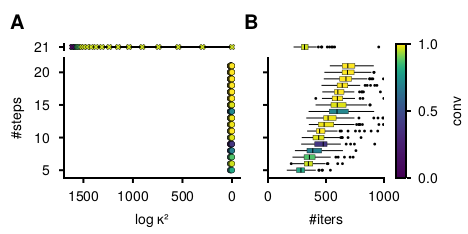

In [316]:
f = Figure(size=(HALF_WIDTH, HEIGHT), figure_padding=5)
perf_axes = f[1, 2] = GridLayout()
schedule_axes = f[1, 1] = GridLayout()
cbar_axes = f[1, 3] = GridLayout()
cmap = cgrad(:viridis, 20, scale=:log)

ax1 = Axis(perf_axes[2, 1], xlabel="#iters", ylabel="#steps"; PLOT_DEFAULTS...)
# scatter!(ax1, metrics[1:end-1, 3], [length(s) for s in tempering_schedules[1:end-1]], colormap=cmap, colorrange=[0, 1], color=metrics[1:end-1, 1], markersize=4, strokecolor=:black, strokewidth=0.2)

iters = [s[:, :iter] for s in only_last_rows_by_schedule]
idxs = [repeat([i], length(s)) for (i, s) in zip(5:21, iters[1:end-1])]
for (idx, iter, color) in zip(idxs, iters[1:end-1], cmap[metrics[1:end-1, 1]])
    boxplot!(ax1, idx, iter, orientation=:horizontal, color=color, boxcolor=:black, whiskercolor=:black, linecolor=:black, mediancolor=:black, width=0.9, strokewidth=0.2, linewidth=0.5, markersize=2, whiskerlinewidth=0.5, medianlinewidth=0.5, outliercolor=:black)
end
xlims!(ax1, 0, 1000)

hidespines!(ax1, :r, :t)
hidedecorations!(ax1, grid=true, label=false, ticks=false, ticklabels=false)
hideydecorations!(ax1, label=true, ticks=false, ticklabels=true)


ax2 = Axis(schedule_axes[2, 1], xlabel="log κ²", ylabel="#steps", xreversed=true; PLOT_DEFAULTS...)
for (i, (c, s)) in enumerate(zip(metrics[:, 1], tempering_schedules[1:end-1]))
    lines!(ax2, log10.(s), repeat([length(s)], length(s)), color=:black, linewidth=1)
    scatter!(ax2, log10.(s), repeat([length(s)], length(s)), markersize=4, colormap=cmap, colorrange=[0, 1], color=metrics_per_κ²[i][:, 1], strokecolor=:black, strokewidth=0.2)
end
ax4 = Axis(perf_axes[1, 1]; PLOT_DEFAULTS...)
hidedecorations!(ax4)
hidedecorations!(ax2, grid=true, label=false, ticks=false, ticklabels=false)
hidespines!(ax4)
rowsize!(perf_axes, 1, Relative(0.1))
rowgap!(perf_axes, 1, Relative(0.0))

ax3 = Axis(schedule_axes[1, 1], xlabel="log κ²"; PLOT_DEFAULTS..., yticks=[21])
lines!(ax3, log10.(tempering_schedules[end]), repeat([length(tempering_schedules[end])], length(tempering_schedules[end])), color=:black, linewidth=1)
scatter!(ax3, log10.(tempering_schedules[end]), repeat([length(tempering_schedules[end])], length(tempering_schedules[end])), markersize=4, colormap=cmap, marker=:x, colorrange=[0, 1], color=reverse(metrics_per_κ²[end][:, 1]), strokecolor=:black, strokewidth=0.2)

hidexdecorations!(ax3, label=true, ticks=true, ticklabels=true, grid=true)
hideydecorations!(ax3, label=true, ticks=false, ticklabels=false, grid=true)
hidespines!(ax3, :r, :t, :b)
rowsize!(schedule_axes, 1, Relative(0.05))
rowgap!(schedule_axes, 1, Relative(0.07))
hidespines!(ax2, :r, :t)
linkyaxes!(ax1, ax2)


# scatter!(ax4, [metrics[end, 3]], [length(tempering_schedules[end])], colormap=cmap, colorrange=[0, 1], color=metrics[end, 1], markersize=4, marker=:x, strokecolor=:black, strokewidth=0.2)
boxplot!(ax4, repeat([21], length(iters[end])), iters[end], orientation=:horizontal, color=cmap[metrics[end, 1]], boxcolor=:black, whiskercolor=:black, linecolor=:black, mediancolor=:black, width=0.9, strokewidth=0.2, linewidth=0.5, markersize=2, whiskerlinewidth=0.5, medianlinewidth=0.5, outliercolor=:black)

hidexdecorations!(ax4, label=true, ticks=true, ticklabels=true, grid=true)
hideydecorations!(ax4, label=true, ticks=false, ticklabels=false, grid=true)
hidespines!(ax4, :r, :t, :b)
rowsize!(perf_axes, 1, Relative(0.05))
rowgap!(perf_axes, 1, Relative(0.07))

colsize!(f.layout, 3, Relative(0.01))
colgap!(f.layout, 2, Relative(0.05))
colsize!(f.layout, 1, Relative(0.6))
colgap!(f.layout, 1, Relative(0.01))
Label(f.layout[1, 1, TopLeft()], "A", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:left)
Label(f.layout[1, 2, TopLeft()], "B", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:left)
cbar = Colorbar(cbar_axes[1, 1], label="conv", limits = (0, 1), colormap=cmap, ticklabelsize=7, ticksize=2, labelsize=7, width=5)

f

In [293]:
save(joinpath(FIGURES_PATH, "appendix_figure7.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}


In [ ]:
# effect of noise

In [144]:
# IN_PATH = RESULTS_PATH * "hh/2p/simple/rk4/l2_noisy_grad"
# FNAMES = readdir(IN_PATH)
# FPATHS = [joinpath(IN_PATH, fname) for fname in FNAMES]

# grad_noise_scales = [0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

# metrics = []
# for (j, decay_rate) in enumerate([0, 5, 10])
#     for (k, scale) in enumerate(grad_noise_scales)
#         fpaths = filter(x -> occursin("$j"*"_$k-", x), FPATHS)
#         trajectories = import_csvs(fpaths, [pkeys(θ)..., :loss, :T])
#         last_rows = vcat([DataFrame(t[end, :]) for t in trajectories]...)
#         θ_est = Array(last_rows[!, pkeys(θ)])
#         pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(θ_est))

#         last_rows[!, :pRMSE] = [pRMSEs...]
#         last_rows[!, :conv] = [(pRMSEs .< 5e-2)...]

#         mean_conv = mean(last_rows[!, :conv])
#         mean_pRMSE = mean(last_rows[!, :pRMSE])
#         mean_num_iter = mean(last_rows[!, :iter])

#         std_pRMSE = std(last_rows[!, :pRMSE])
#         std_num_iter = std(last_rows[!, :iter])

#         push!(metrics, [scale, decay_rate, mean_conv, mean_pRMSE, std_pRMSE, mean_num_iter, std_num_iter])
#     end
# end

# metrics = hcat(metrics...)'
# metrics = DataFrame(metrics, [:scale, :decay_rate, :mean_conv, :mean_pRMSE, :std_pRMSE, :mean_num_iter, :std_num_iter])
# println(metrics)

In [172]:
IN_PATH = RESULTS_PATH * "pd/1p/single_pendulum/rk4/l2_noisy_grad"
FNAMES = readdir(IN_PATH)
FPATHS = [joinpath(IN_PATH, fname) for fname in FNAMES]

grad_noise_scales = [0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

metrics = []
for (j, decay_rate) in enumerate([0, 5, 10])
    for (k, scale) in enumerate(grad_noise_scales)
        fpaths = filter(x -> occursin("$j"*"_$k-", x), FPATHS)
        trajectories = import_csvs(fpaths, [:l, :loss, :T])
        last_rows = vcat([DataFrame(t[end, :]) for t in trajectories]...)
        θ_est = Array(last_rows[!, [:l]])
        pRMSEs = map(x -> rel_pRMSE(x, [3.0]), eachrow(θ_est))

        last_rows[!, :pRMSE] = [pRMSEs...]
        last_rows[!, :conv] = [(pRMSEs .< 5e-2)...]

        mean_conv = mean(last_rows[!, :conv])
        mean_pRMSE = mean(last_rows[!, :pRMSE])
        mean_iter = mean(last_rows[!, :iter])

        std_pRMSE = std(last_rows[!, :pRMSE])
        std_iter = std(last_rows[!, :iter])

        push!(metrics, [scale, decay_rate, mean_conv, mean_pRMSE, std_pRMSE, mean_iter, std_iter])
    end
end

metrics = hcat(metrics...)'
metrics = DataFrame(metrics, [:scale, :decay_rate, :conv, :mean_pRMSE, :std_pRMSE, :mean_iter, :std_iter])
println(metrics)

30×7 DataFrame
 Row │ scale    decay_rate  conv     mean_pRMSE  std_pRMSE  mean_iter  std_iter 
     │ Float64  Float64     Float64  Float64     Float64    Float64    Float64  
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.0          0.0     0.32    1.42454    1.09027       33.47  18.1077
   2 │    0.01         0.0     0.35    1.40087    1.11206       33.79  12.8396
   3 │    0.05         0.0     0.34    1.41001    1.10422       29.89  10.7674
   4 │    0.1          0.0     0.37    1.40297    1.12603       27.3   11.8369
   5 │    0.5          0.0     0.49    1.14034    1.12978       15.19  10.723
   6 │    1.0          0.0     0.63    0.770379   1.04765       15.52  14.1196
   7 │    5.0          0.0     0.64    0.509967   0.881543      13.01   8.86771
   8 │   10.0          0.0     0.39    0.642715   0.930597      10.43   7.19323
   9 │   50.0          0.0     0.45    0.488851   0.83071       11.66   8.26117
  10 │  100.0          0.0   

In [178]:
metrics_latex_table = pretty_table(String, metrics; backend=Val(:latex), show_subheader=false, formatters=ft_printf("%.2f"))
metrics_latex_table = merge_means_and_std_cols(metrics_latex_table)
# pretty_table(metrics, show_subheader=false, formatters=ft_printf("%.2f"))

print(metrics_latex_table)

\begin{tabular}{rrrrrrr}
  \hline
  \textbf{scale} & \textbf{decay\_rate} & \textbf{conv} & \textbf{mean\_pRMSE} pm \textbf{std\_pRMSE} & \textbf{mean\_iter} pm \textbf{std\_iter} \\\hline
  0.00 & 0.00 & 0.32 & 1.42 pm 1.09 & 33.47 pm 18.11 \\
  0.01 & 0.00 & 0.35 & 1.40 pm 1.11 & 33.79 pm 12.84 \\
  0.05 & 0.00 & 0.34 & 1.41 pm 1.10 & 29.89 pm 10.77 \\
  0.10 & 0.00 & 0.37 & 1.40 pm 1.13 & 27.30 pm 11.84 \\
  0.50 & 0.00 & 0.49 & 1.14 pm 1.13 & 15.19 pm 10.72 \\
  1.00 & 0.00 & 0.63 & 0.77 pm 1.05 & 15.52 pm 14.12 \\
  5.00 & 0.00 & 0.64 & 0.51 pm 0.88 & 13.01 pm 8.87 \\
  10.00 & 0.00 & 0.39 & 0.64 pm 0.93 & 10.43 pm 7.19 \\
  50.00 & 0.00 & 0.45 & 0.49 pm 0.83 & 11.66 pm 8.26 \\
  100.00 & 0.00 & 0.28 & 0.44 pm 0.74 & 10.26 pm 7.42 \\
  0.00 & 5.00 & 0.32 & 1.42 pm 1.09 & 33.47 pm 18.11 \\
  0.01 & 5.00 & 0.31 & 1.45 pm 1.08 & 35.94 pm 18.58 \\
  0.05 & 5.00 & 0.33 & 1.45 pm 1.10 & 32.58 pm 13.39 \\
  0.10 & 5.00 & 0.35 & 1.40 pm 1.11 & 33.65 pm 12.85 \\
  0.50 & 5.00 & 0.43 & 1.24

In [185]:
pretty_table(metrics[[1,7,end-3], :], show_subheader=false, formatters=ft_printf("%.2f"))

┌───────┬────────────┬──────┬────────────┬───────────┬───────────┬──────────┐
│ scale │ decay_rate │ conv │ mean_pRMSE │ std_pRMSE │ mean_iter │ std_iter │
├───────┼────────────┼──────┼────────────┼───────────┼───────────┼──────────┤
│  0.00 │       0.00 │ 0.32 │       1.42 │      1.09 │     33.47 │    18.11 │
│  5.00 │       0.00 │ 0.64 │       0.51 │      0.88 │     13.01 │     8.87 │
│  5.00 │      10.00 │ 0.61 │       0.58 │      0.94 │     14.28 │    12.63 │
└───────┴────────────┴──────┴────────────┴───────────┴───────────┴──────────┘
